#### Clone repository

In [ ]:
!git clone https://github.com/ManuelZ/pairwise-similarity.git

#### Download data

In [ ]:
!wget -nc <<FILL ME>>/oracle-cards.zip
!wget -nc <<FILL ME>>/oracle-cards-subset.zip

#### Unzip data

In [ ]:
!apt update && apt install -y unzip
!unzip -nq oracle-cards.zip
!unzip -nq oracle-cards-subset.zip

#### Change directory

In [1]:
import os
os.chdir(r'/workspace/image-search-engine/backend')

#### Install requirements

In [ ]:
!pip install --quiet --upgrade pip && pip install --quiet -r requirements.txt

In [2]:
# External imports
import cv2
import torch 
import faiss
import matplotlib.pyplot as plt

# Local imports
from siamese_pt.model import create_model
from siamese_pt.dataset import common_transforms
from siamese_pt.create_index import create_faiss_index
from siamese_pt.train import train_dataset
from test_index import read_index, query_index, display_query_results
from utils import torch_to_cv2, denormalize, get_image_paths
import config

#### Visualize augmentations

<Figure size 1200x600 with 0 Axes>

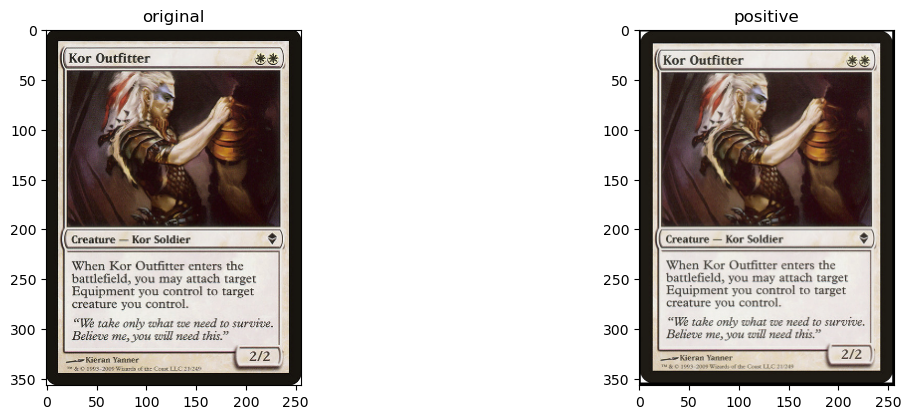

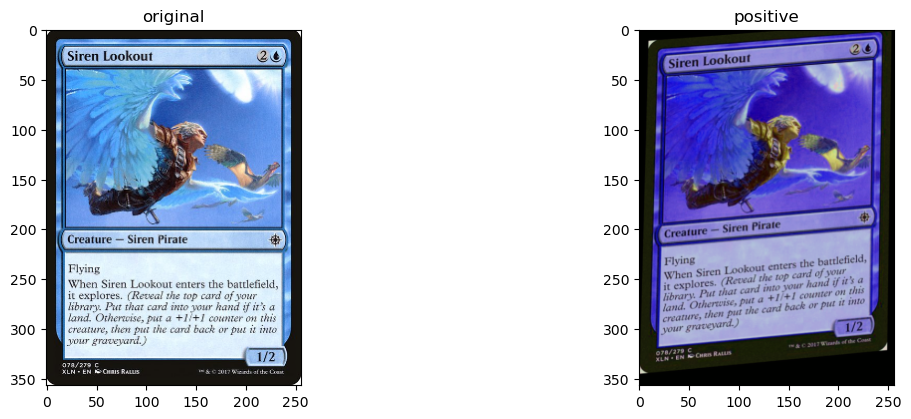

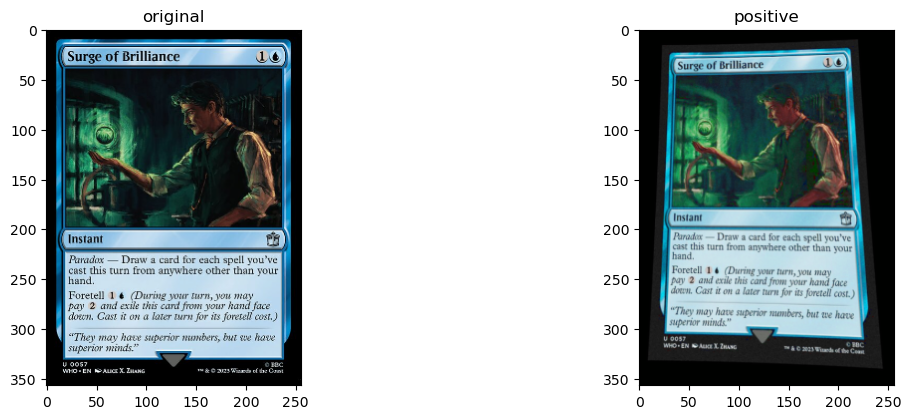

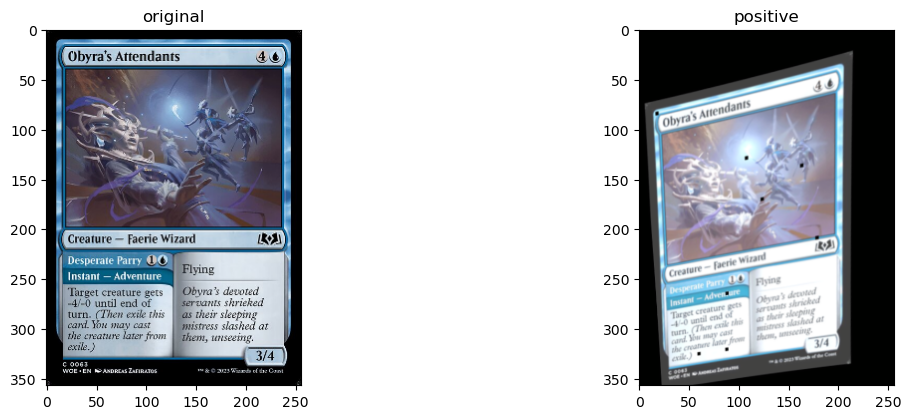

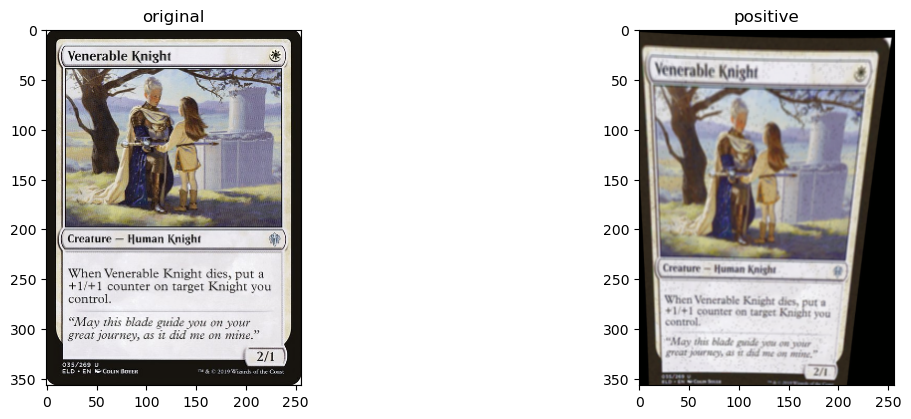

In [3]:
fig = plt.figure(figsize=(12, 6))  # w,h

num_cards = 5

for i, (original, positive) in enumerate(train_dataset):

    if i == num_cards:
        break
    
    original = denormalize(original)
    original = torch_to_cv2(original)

    positive = denormalize(positive)
    positive = torch_to_cv2(positive)

    fig = plt.figure(figsize=(12, 8))  # w,h
    
    plt.subplot(2, 2, 1)
    plt.imshow(original)
    plt.title("original")

    plt.subplot(2, 2, 2)
    plt.imshow(positive)
    plt.title("positive")

    plt.tight_layout()


plt.show()

#### Train

In [ ]:
!python -m siamese_pt.train

#### Create index

In [ ]:
model = create_model()
checkpoint = torch.load(config.LOAD_MODEL_PATH_PT, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

create_faiss_index(model, config.DATA, config.FAISS_INDEX_PATH)

#### Test index

There are 40 images for querying.
There are 30467 observations in the index


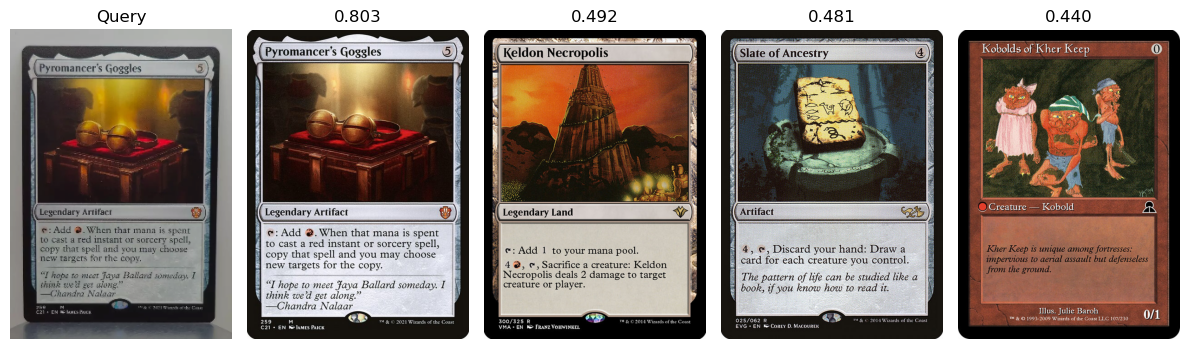

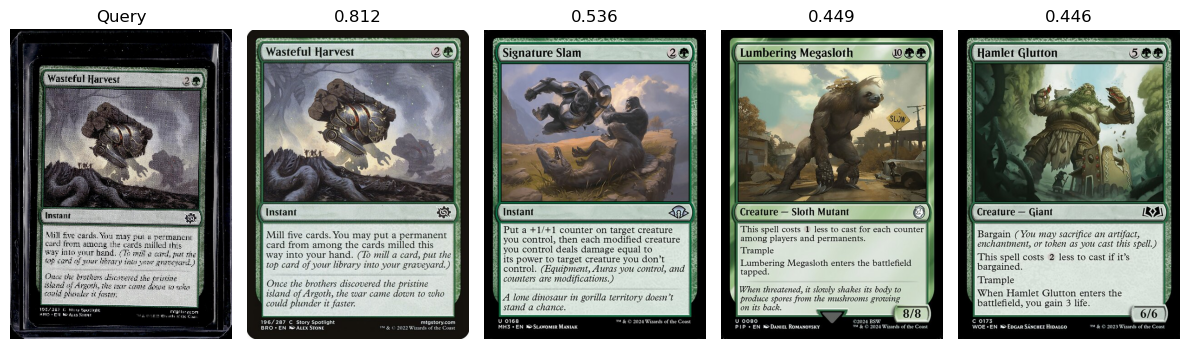

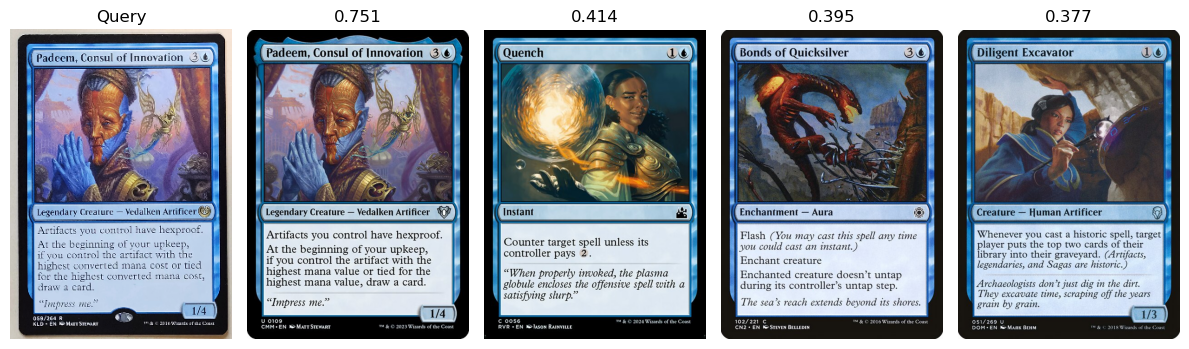

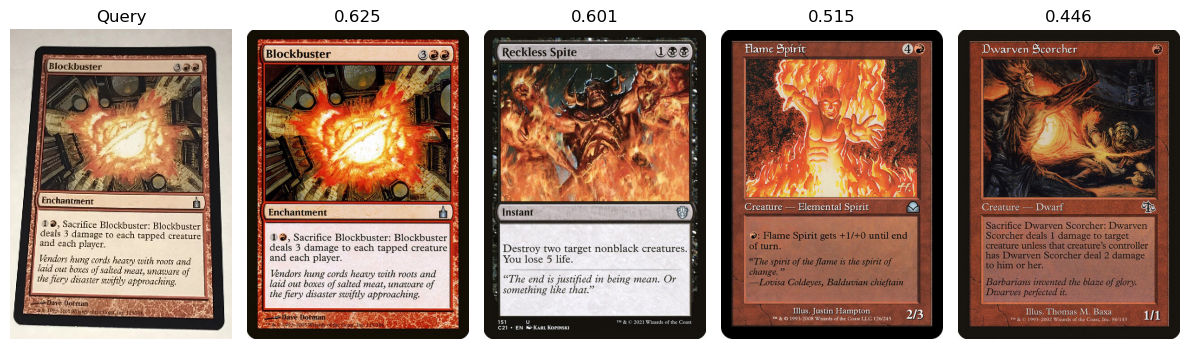

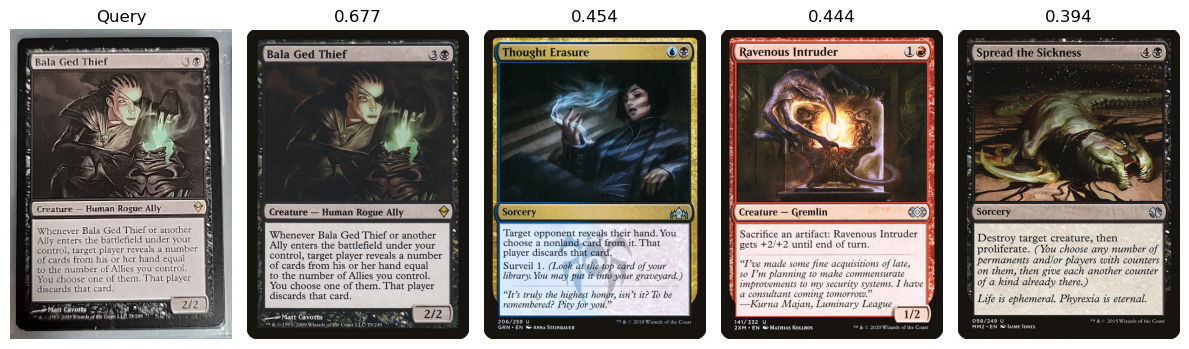

In [4]:
model = create_model()
checkpoint = torch.load(config.LOAD_MODEL_PATH_PT, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
query_paths = get_image_paths(config.QUERY_DATASET)
print(f"There are {len(query_paths)} images for querying.")

num_cards = 5

index = read_index()
for i, impath in enumerate(query_paths):

    if i == num_cards:
        break
    
    image = cv2.imread(impath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = common_transforms(image=image)["image"]
    image = image.to(device, dtype=torch.float32)
    image = image.unsqueeze(0)
    embedding = model(image)
    embedding = embedding.detach().cpu().numpy()
    faiss.normalize_L2(embedding)

    indices, distances = query_index(
        embedding, index, config.INDEX_TYPE, n_results=4
    )

    image = denormalize(image)
    image = torch_to_cv2(image)
    display_query_results(image, distances, indices, nrows=1, ncols=5)